# 🏦 Home Credit Default Risk Prediction
**Objective:** Predict whether a client will default on a loan using structured financial and application data.

**Dataset:** [Home Credit Default Risk - Kaggle](https://www.kaggle.com/competitions/home-credit-default-risk)

**Model Used:** LightGBM   
**Evaluation Metric:** ROC-AUC, Precision, Recall, SHAP Interpretability  


In [ ]:
# ---------------------------------------------------------------
# 🔑 Kaggle API Setup (Uncomment below if using Google Colab)
# ---------------------------------------------------------------

# Step 1: Upload your kaggle.json (API token)
# from google.colab import files
# files.upload()  # Upload kaggle.json from your local machine

# Step 2: Set up Kaggle API access
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

# Step 3: Download and unzip the dataset
# !kaggle competitions download -c home-credit-default-risk
# !unzip home-credit-default-risk.zip


# Importing required libraries

In [7]:
# Core Libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model & Evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_recall_curve, RocCurveDisplay
)

# LightGBM
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation

# Model Explainability
import shap

## 🔍 Step 1: Load and Explore Main Dataset
We start with the `application_train.csv` which contains the primary loan application data.


In [8]:
# Load the main training data
df = pd.read_csv('application_train.csv')

# View the shape and first few rows
print("Shape:", df.shape)
df.head()

Shape: (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# Check data types and missing values
df.info()

# Count of target classes (0 = repaid, 1 = defaulted)
print(df['TARGET'].value_counts())
print(df['TARGET'].value_counts(normalize=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB
TARGET
0    282686
1     24825
Name: count, dtype: int64
TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64


In [10]:
# Summary stats
df.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000




Visualizing how many applicants repaid (`TARGET = 0`) vs defaulted (`TARGET = 1`).  
This helps us understand class imbalance, which is crucial for model performance and evaluation strategy.


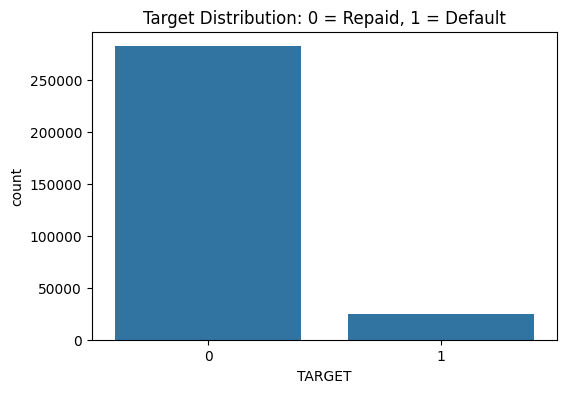

In [11]:
# Distribution of "Target"
plt.figure(figsize=(6,4))
sns.countplot(x='TARGET', data=df)
plt.title("Target Distribution: 0 = Repaid, 1 = Default")
plt.show()

## 🧹 Step 2: Data Cleaning & Missing Value Handling
We remove columns with >40% missing values and drop ID-only columns.


In [12]:
# Count missing values
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
missing[:10]

,0
COMMONAREA_MEDI,214865
COMMONAREA_MODE,214865
COMMONAREA_AVG,214865
NONLIVINGAPARTMENTS_MODE,213514
NONLIVINGAPARTMENTS_MEDI,213514
NONLIVINGAPARTMENTS_AVG,213514
FONDKAPREMONT_MODE,210295
LIVINGAPARTMENTS_AVG,210199
LIVINGAPARTMENTS_MEDI,210199
LIVINGAPARTMENTS_MODE,210199


In [13]:
# Drop features with >40% missing or irrelevant IDs
high_missing = missing[missing > 0.4 * len(df)].index

df.drop(columns=list(high_missing), inplace=True)
print("Remaining columns:", df.shape[1])

Remaining columns: 73


## 🔁 Reintroduce EXT_SOURCE_1 Feature

Since `EXT_SOURCE_1` has high correlation with the target but was previously dropped due to missing values,  
we reload and merge it back into our main dataset for potential performance improvement.


In [14]:
# Step 1: Reload only 'SK_ID_CURR' and 'EXT_SOURCE_1' from original dataset
ext1 = pd.read_csv("application_train.csv", usecols=['SK_ID_CURR', 'EXT_SOURCE_1'])

# Step 2: Merge it back to the working dataframe using SK_ID_CURR
df = df.merge(ext1, on='SK_ID_CURR', how='left')  # 'left' keeps all rows in df

# Show updated number of columns
print("No. of columns:", df.shape[1])

No. of columns: 74


In [15]:
# Simple imputation
df.fillna(df.median(numeric_only=True), inplace=True)

## 🏗️ Step 3: Feature Engineering from External Files
We aggregate useful statistics from Bureau, Previous Applications, Installments & Credit Card Balance datasets.


In [16]:
# Create custom ratio features
df['CREDIT_INCOME_RATIO'] = df['AMT_CREDIT'] / (df['AMT_INCOME_TOTAL'] + 1)
df['ANNUITY_INCOME_RATIO'] = df['AMT_ANNUITY'] / (df['AMT_INCOME_TOTAL'] + 1)
df['EMPLOYED_BIRTH_RATIO'] = df['DAYS_EMPLOYED'] / (df['DAYS_BIRTH'] + 1)

In [17]:
#loading other files ffrom dataset
bureau = pd.read_csv("bureau.csv")
previous = pd.read_csv("previous_application.csv")
installments = pd.read_csv("installments_payments.csv")
credit_card = pd.read_csv("credit_card_balance.csv")

Using bureau.csv

In [18]:
# Create new ratio & duration features
bureau['DEBT_CREDIT_RATIO'] = bureau['AMT_CREDIT_SUM_DEBT'] / bureau['AMT_CREDIT_SUM']
bureau['DEBT_CREDIT_RATIO'].replace([np.inf, -np.inf], np.nan, inplace=True)

bureau['CREDIT_DURATION'] = bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_CREDIT']
bureau['CREDIT_DURATION'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Perform aggregation
bureau_agg = bureau.groupby('SK_ID_CURR').agg({
    'SK_ID_BUREAU': 'count',  # total number of previous loans
    'AMT_CREDIT_SUM': ['mean', 'max'],
    'AMT_CREDIT_SUM_DEBT': ['mean', 'sum'],
    'CREDIT_DAY_OVERDUE': ['mean', 'max'],
    'AMT_ANNUITY': 'mean',
    'DAYS_CREDIT_ENDDATE': ['min', 'max'],
    'DAYS_CREDIT_UPDATE': 'max',
    'CREDIT_ACTIVE': lambda x: (x == 'Active').sum(),
    'DEBT_CREDIT_RATIO': ['mean', 'max'],
    'CREDIT_DURATION': ['mean', 'max']
})

# Flatten MultiIndex columns
bureau_agg.columns = ['BUREAU_' + '_'.join(col).upper() if isinstance(col, tuple) else 'BUREAU_' + col for col in bureau_agg.columns]
bureau_agg.reset_index(inplace=True)

# Merge into main dataframe
df = df.merge(bureau_agg, on='SK_ID_CURR', how='left')

/tmp/ipython-input-18-967393983.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  bureau['DEBT_CREDIT_RATIO'].replace([np.inf, -np.inf], np.nan, inplace=True)
/tmp/ipython-input-18-967393983.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].meth

Using previous_application.csv

In [19]:
# Create useful ratio features before aggregation
previous['APP_CREDIT_RATIO'] = previous['AMT_APPLICATION'] / previous['AMT_CREDIT']
previous['APP_CREDIT_RATIO'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Optional: flag for rejected applications
previous['REJECTED'] = (previous['NAME_CONTRACT_STATUS'] == 'Refused').astype(int)

# Aggregate all features grouped by SK_ID_CURR
prev_agg = previous.groupby('SK_ID_CURR').agg({
    'SK_ID_PREV': 'count',  # number of previous applications
    'AMT_APPLICATION': ['mean', 'max'],
    'AMT_CREDIT': ['mean', 'max'],
    'APP_CREDIT_RATIO': ['mean', 'min'],
    'AMT_ANNUITY': ['mean'],
    'DAYS_FIRST_DRAWING': 'min',
    'DAYS_LAST_DUE_1ST_VERSION': 'max',
    'DAYS_DECISION': ['mean', 'min'],
    'REJECTED': 'mean'
})

# Flatten MultiIndex columns
prev_agg.columns = ['PREV_' + '_'.join(col).upper() if isinstance(col, tuple) else 'PREV_' + col for col in prev_agg.columns]
prev_agg.reset_index(inplace=True)

# Merge with main dataset
df = df.merge(prev_agg, on='SK_ID_CURR', how='left')

/tmp/ipython-input-19-3221623740.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  previous['APP_CREDIT_RATIO'].replace([np.inf, -np.inf], np.nan, inplace=True)


Using installments_payments.csv

In [20]:
# Calculate payment delay and overpayment
installments['PAYMENT_DELAY'] = installments['DAYS_ENTRY_PAYMENT'] - installments['DAYS_INSTALMENT']
installments['OVERPAID'] = installments['AMT_PAYMENT'] - installments['AMT_INSTALMENT']

# Group by customer ID
inst_agg = installments.groupby('SK_ID_CURR').agg({
    'SK_ID_PREV': 'nunique',
    'NUM_INSTALMENT_VERSION': 'nunique',
    'DAYS_INSTALMENT': ['mean', 'max'],
    'DAYS_ENTRY_PAYMENT': ['mean'],
    'AMT_INSTALMENT': ['mean', 'sum'],
    'AMT_PAYMENT': ['mean', 'sum'],
    'PAYMENT_DELAY': ['mean', 'max'],
    'OVERPAID': ['mean', 'min']
})

# Flatten column names
inst_agg.columns = ['INST_' + '_'.join(col).upper() for col in inst_agg.columns]
inst_agg.reset_index(inplace=True)

# Merge with main dataset
df = df.merge(inst_agg, on='SK_ID_CURR', how='left')

Using credit_card_balance.csv

In [21]:
# Group by customer ID
cc_agg = credit_card.groupby('SK_ID_CURR').agg({
    'SK_ID_PREV': 'nunique',
    'MONTHS_BALANCE': ['min', 'max'],
    'AMT_BALANCE': ['mean', 'max'],
    'AMT_CREDIT_LIMIT_ACTUAL': ['mean'],
    'AMT_DRAWINGS_ATM_CURRENT': ['mean'],
    'AMT_DRAWINGS_CURRENT': ['mean'],
    'AMT_PAYMENT_TOTAL_CURRENT': ['mean', 'sum'],
    'CNT_DRAWINGS_CURRENT': ['mean', 'max'],
    'SK_DPD': ['mean', 'max']  # Days past due
})

# Flatten column names
cc_agg.columns = ['CC_' + '_'.join(col).upper() for col in cc_agg.columns]
cc_agg.reset_index(inplace=True)

# Merge with main dataset
df = df.merge(cc_agg, on='SK_ID_CURR', how='left')

Feature Engineering: Interaction and Ratio Features

In [22]:
# Feature Engineering: Interaction and Ratio Features

# 1. Interaction Features
df['EXT_SOURCE_1_x_2'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2']
df['EXT_SOURCE_1_x_3'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_3']
df['EXT_SOURCE_2_x_3'] = df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
df['EXT_SOURCE_Mean'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
df['EXT_SOURCE_STD'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
df['EXT_SOURCE_Weighted'] = (df['EXT_SOURCE_1'] * 0.2 + df['EXT_SOURCE_2'] * 0.4 + df['EXT_SOURCE_3'] * 0.4)

# 2. Ratio Features
df['ANNUITY_INCOME_RATIO'] = df['AMT_ANNUITY'] / (df['AMT_INCOME_TOTAL'] + 1)
df['CREDIT_INCOME_RATIO'] = df['AMT_CREDIT'] / (df['AMT_INCOME_TOTAL'] + 1)
df['GOODS_INCOME_RATIO'] = df['AMT_GOODS_PRICE'] / (df['AMT_INCOME_TOTAL'] + 1)
df['EMPLOYED_BIRTH_RATIO'] = df['DAYS_EMPLOYED'] / (df['DAYS_BIRTH'] + 1)
df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / (df['CNT_FAM_MEMBERS'] + 1)

# 3. Binary Flags
df['HAS_CHILDREN'] = (df['CNT_CHILDREN'] > 0).astype(int)
df['IS_OWN_CAR_HOUSE'] = ((df['FLAG_OWN_CAR'] == 1) & (df['FLAG_OWN_REALTY'] == 1)).astype(int)

# 4. Log Features (optional but may help skewed data)
df['LOG_AMT_INCOME_TOTAL'] = np.log1p(df['AMT_INCOME_TOTAL'])
df['LOG_AMT_CREDIT'] = np.log1p(df['AMT_CREDIT'])
df['LOG_AMT_ANNUITY'] = np.log1p(df['AMT_ANNUITY'])


No. of columns after Feature Engineering

In [23]:
print("No. of columns:", df.shape[1])

No. of columns: 146


 Replace extreme values

In [24]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True)

## 🔤 Label Encoding of Categorical Features

We apply `LabelEncoder` to convert all object-type (categorical) columns into numerical values.  
This is necessary for algorithms like LightGBM, Random Forest, etc., that don’t natively handle string/object types.


In [25]:
from sklearn.preprocessing import LabelEncoder

# Identify all categorical columns
cat_cols = df.select_dtypes('object').columns

# Initialize label encoder
le = LabelEncoder()

# Encode each categorical column
for col in cat_cols:
    df[col] = le.fit_transform(df[col].astype(str))  # Ensure all values are string before encoding

## 🔗 Correlation Heatmap of Top Features

We compute correlation between features and `TARGET` and plot a heatmap of the top 15 most correlated features.  
This helps identify which features might be predictive of loan default.


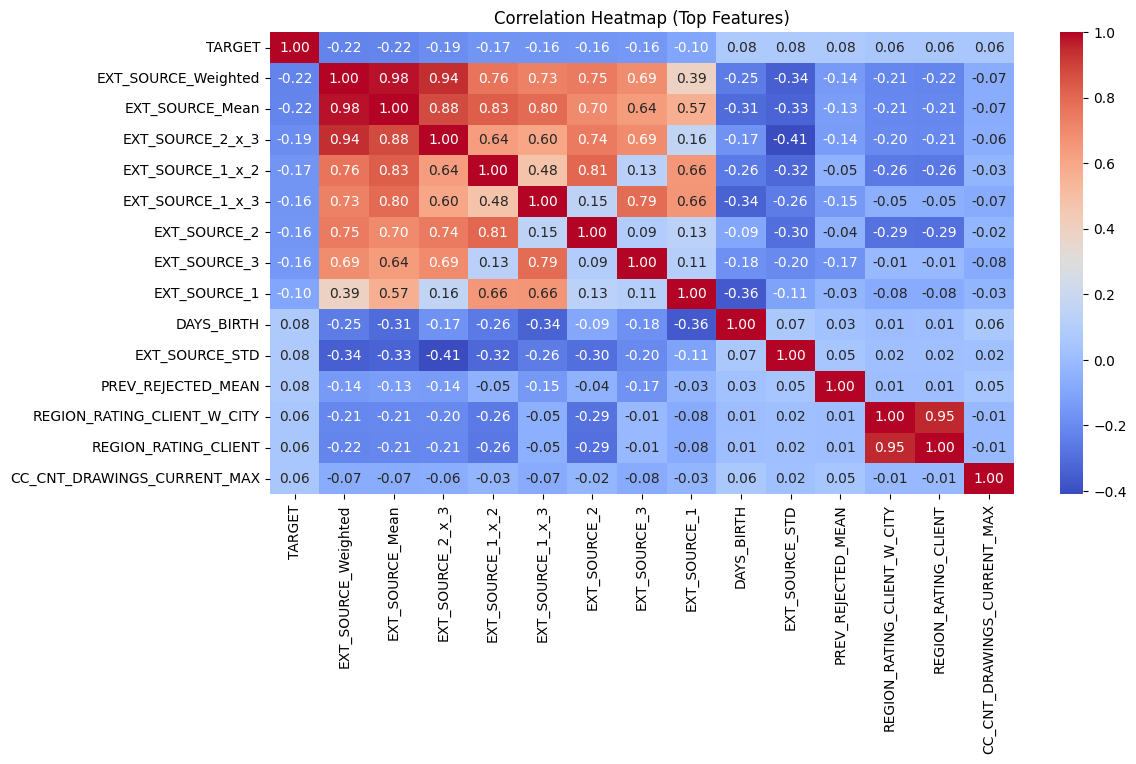

In [26]:
# Compute correlation matrix (numeric features only)
corr = df.corr(numeric_only=True)

# Get top 15 features most correlated with the target (absolute correlation)
top_corr = corr['TARGET'].abs().sort_values(ascending=False).head(15).index

# Plot heatmap of correlations among top correlated features
plt.figure(figsize=(12,6))
sns.heatmap(df[top_corr].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap (Top Features)")
plt.show()

## ✂️ Step 4: Train-Test Split
We separate features and target, and create test and train sets.


In [27]:
from sklearn.model_selection import train_test_split

# Separate features and target
X = df.drop(columns=['SK_ID_CURR', 'TARGET'])
y = df['TARGET']

# Stratify to preserve class imbalance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (246008, 144)
Test shape: (61503, 144)


## ⚖️ Check Class Imbalance in Training Set

Before training, we check how imbalanced the `TARGET` variable is. This helps guide model decisions (like using `class_weight='balanced'` or SMOTE).


In [28]:
# Count of each class in the training set
print(y_train.value_counts())

# Ratio of non-defaulters (0) to defaulters (1)
print("Ratio:", round(y_train.value_counts()[0] / y_train.value_counts()[1], 2))

TARGET
0    226148
1     19860
Name: count, dtype: int64
Ratio: 11.39


## ⚙️ Step 5: Model Training with LGBM (Class Imbalance Handled)


In [29]:
# Initialize the LGBM Classifier
model = lgb.LGBMClassifier(
    n_estimators=1000,        # Number of boosting rounds
    learning_rate=0.05,       # Step size shrinkage
    max_depth=-1,             # No limit on depth
    random_state=42,          # For reproducibility
    class_weight='balanced',  # Automatically adjust weights inversely proportional to class frequencies
    objective='binary',       # Binary classification
    n_jobs=-1                 # Use all available CPU cores
)

In [30]:
from lightgbm import early_stopping, log_evaluation

# Fit the model with early stopping and evaluation logging
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],        # Use test set as validation
    callbacks=[
        early_stopping(stopping_rounds=50),  # Stop if no improvement for 50 rounds
        log_evaluation(period=100)           # Log metrics every 100 iterations
    ]
)

[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.316170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18919
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 139
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.558265
[200]	valid_0's binary_logloss: 0.538611
[300]	valid_0's binary_logloss: 0.526506
[400]	valid_0's binary_logloss: 0.516113
[500]	valid_0's binary_logloss: 0.506673
[600]	valid_0's binary_logloss: 0.497907
[700]	valid_0's binary_logloss: 0.489619
[800]	valid_0's binary_logloss: 0.481439
[900]	valid_0's binary_logloss: 0.47423
[1000]	valid_0's binary_logloss: 0.467278
Did not meet early stopping. Be

LGBMClassifier(class_weight='balanced', learning_rate=0.05, n_estimators=1000,
               n_jobs=-1, objective='binary', random_state=42)

## 📊 Step 6: Evaluation - Classification Metrics, ROC, PR Curve
We compute confusion matrix, precision, recall, and ROC-AUC.


Confusion Matrix:
 [[46947  9591]
 [ 2177  2788]]

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.83      0.89     56538
           1       0.23      0.56      0.32      4965

    accuracy                           0.81     61503
   macro avg       0.59      0.70      0.61     61503
weighted avg       0.90      0.81      0.84     61503


ROC-AUC Score: 0.78134386316013


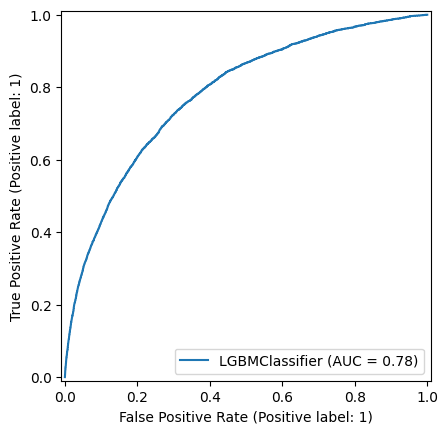

In [31]:
y_proba = model.predict_proba(X_test)[:, 1]

threshold = 0.55  # example based on graph
y_pred = (y_proba >= threshold).astype(int)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nROC-AUC Score:", roc_auc_score(y_test, y_proba))

RocCurveDisplay.from_estimator(model, X_test, y_test)

Precision Recall Curve

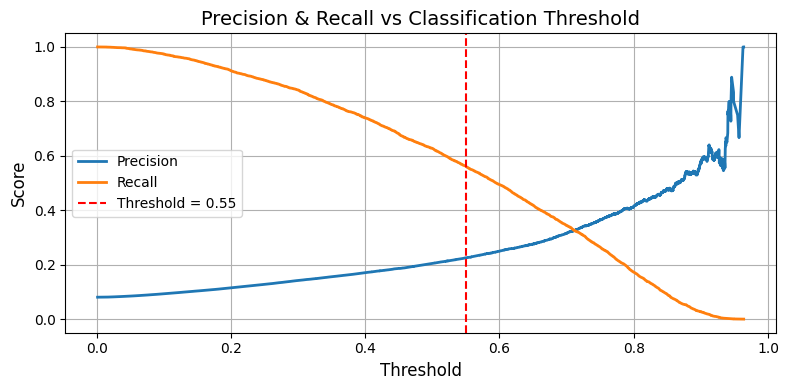

In [32]:


# Calculate precision, recall, thresholds
prec, rec, thresh = precision_recall_curve(y_test, y_proba)

# Create a larger figure
plt.figure(figsize=(8, 4))

# Plot Precision and Recall vs Threshold
plt.plot(thresh, prec[:-1], label="Precision", linewidth=2)
plt.plot(thresh, rec[:-1], label="Recall", linewidth=2)

# Optional: Mark chosen threshold
plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold:.2f}')

# Add labels and grid
plt.xlabel("Threshold", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.title("Precision & Recall vs Classification Threshold", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 🔍 Step 7: SHAP Interpretability
We use SHAP to understand what features influenced predictions.


In [33]:
# Sample safely
X_sample = X_test.sample(300, random_state=42)

# Use TreeExplainer
explainer = shap.TreeExplainer(model)

# Compute SHAP values
shap_values = explainer.shap_values(X_sample)

/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


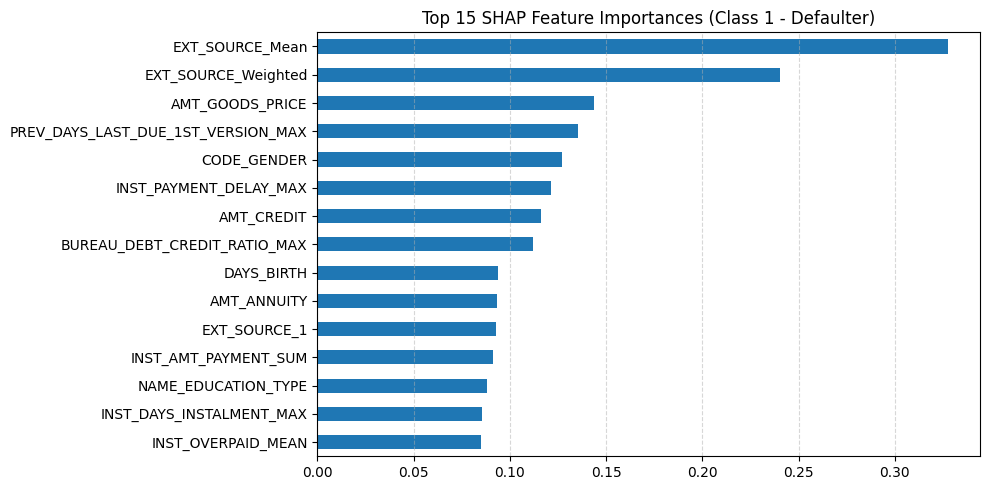

In [34]:

# Select class 1 (defaulter) SHAP values
shap_class1 = shap_values[1] if isinstance(shap_values, list) else shap_values

# Compute mean absolute SHAP value per feature
shap_importance = np.abs(shap_class1).mean(axis=0)

# Create pandas Series for easy plotting
importance_df = pd.Series(shap_importance, index=X_sample.columns).sort_values(ascending=False)[:15]

# Plot
plt.figure(figsize=(10, 5))
importance_df.plot(kind='barh')
plt.title("Top 15 SHAP Feature Importances (Class 1 - Defaulter)")
plt.gca().invert_yaxis()
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## ✅ Final Summary
- Best ROC-AUC achieved: 0.78  
- SHAP showed EXT_SOURCE Features,GOOD PRICE, AGE, GENDER, CREDIT_HISTORY.... as most Important Features
- Precision/Recall tuned using threshold 0.55 to prioritize catching defaulters